## Evaluate All models
Zeyu Tang \
Clemson University \
07/2025 \
tmc_results.ipynb \
Purpose: evaluate ligament, kinematic and image models independently and via ensemble strategy; plot results

### Dependencies

In [20]:
import glob
import numpy as np
import os
import collections
import sys

import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt

import cv2
import imageio
import csv

from scipy import signal
from scipy.ndimage import uniform_filter1d


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from torchvision import transforms
from torchinfo import summary

import argparse
import yaml
import xgboost as xgb 

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from filters import sliding_filter, hysteresis_threshold_segment, sliding_slope_filter


%load_ext autoreload


ModuleNotFoundError: No module named 'filters'

In [21]:
plt.rcParams['font.size'] = 14 

In [22]:
with open('configs.yaml', 'r') as file:
    configs = yaml.safe_load(file)

#### XGBoost on static data
Scripts for data processing, training, and testing are in notebook 'tmc_xgboost.ipynb'.\
Use stored results for analysis

Accuracy: 0.3125
Precision: 0.3125
Recall: 0.3125
F1: 0.3125
weighted acc: 0.2409090909090909


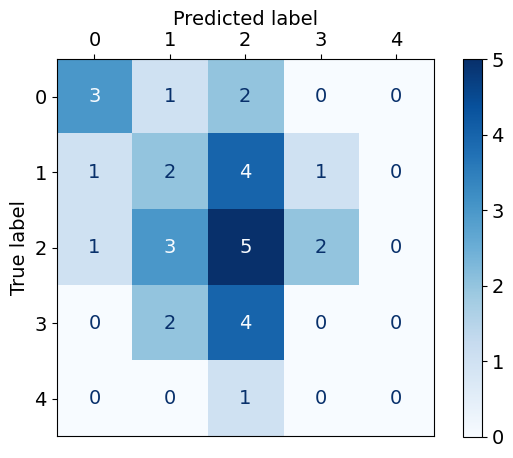

In [23]:
'''Old grading scheme
'''
df_image_old = pd.read_csv(os.path.join(configs['results_path'],'static_model', 'result_1.csv'))
all_preds = df_image_old['Prediction'].to_list()
all_labels = df_image_old['Ground Truth'].to_list()

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
f1 = 2 * (precision * recall) / (precision + recall)

weighted_accuracy = balanced_accuracy_score(all_labels, all_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'weighted acc: {weighted_accuracy}')

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
fig.savefig('./figures/cm_static_old.jpg', dpi=300)

Accuracy: 0.6875
Precision: 0.6875
Recall: 0.6875
F1: 0.6875
weighted acc: 0.5458937198067633


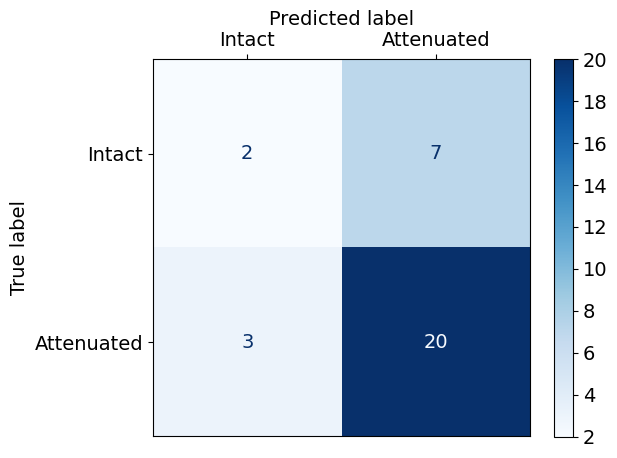

In [24]:
'''New grading scheme
'''
df_image_new = pd.read_csv(os.path.join(configs['results_path'],'static_model', 'result_ligament.csv'))
all_preds = df_image_new['Prediction'].to_list()
all_labels = df_image_new['Ground Truth'].to_list()

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
f1 = 2 * (precision * recall) / (precision + recall)
weighted_accuracy = balanced_accuracy_score(all_labels, all_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'weighted acc: {weighted_accuracy}')


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Intact','Attenuated'])
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
fig.savefig('./figures/cm_static_new.jpg', dpi=300)



#### paralleled CNN-LSTM on kinematic data
Scripts for data processing, training, and testing are under folder 'kinematic_model'.
- Usage:
    - python run.py
    - run.sh under linux environment
    
Use stored results for analysis

Accuracy: 0.3548387096774194
Precision: 0.3548387096774194
Recall: 0.3548387096774194
F1: 0.35483870967741943
weighted acc: 0.27575757575757576


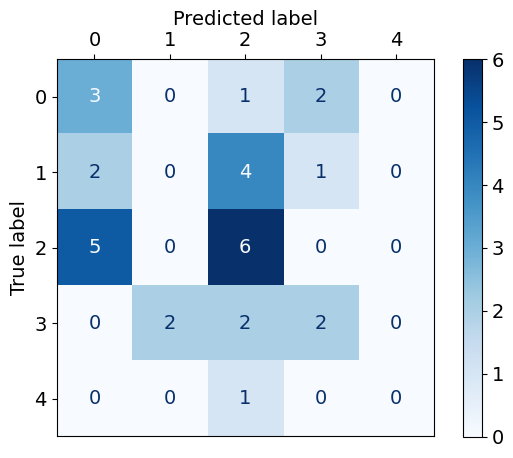

In [25]:
'''Old grading scheme
'''
df_kinematic_old = pd.read_csv(os.path.join(configs['results_path'], 'kinematic_model', f'result_old_ch_all.csv'))
all_preds = df_kinematic_old['Prediction'].to_list()

all_labels = df_kinematic_old['Ground Truth'].to_list()

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
f1 = 2 * (precision * recall) / (precision + recall)
weighted_accuracy = balanced_accuracy_score(all_labels, all_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'weighted acc: {weighted_accuracy}')

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
# fig.savefig('./figures/cm_kinematic_old.pdf', dpi=300)
fig.savefig('./figures/cm_kinematic_old.jpg', dpi=300)


''' Summarize results for using each single feature channels '''

kinematic_channels = ['helical_angle',
             'helical_translation',
             'volar-dorsal_angle',
             'volar-dorsal_translation',
             'radial-ulnar_angle',
             'radial-ulnar_translation',
             'inferior-superior_angle',
             'inferior-superior_translation']
res = collections.defaultdict(list)
for ch in range(8):
    df_kinematic_new = pd.read_csv(os.path.join(configs['results_path'], 'kinematic_model', f'result_contras_ch_{ch}.csv'))
    all_preds = df_kinematic_new['Prediction'].to_list()
    all_labels = df_kinematic_new['Ground Truth'].to_list()

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', pos_label=1)
    recall = recall_score(all_labels, all_preds, average='binary', pos_label=1)
    if precision + recall:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    res['channel'].append(kinematic_channels[ch])
    res['accuracy'].append(accuracy)
    res['f1'].append(f1)
    res['precision'].append(precision)
    res['recall'].append(recall)

df = pd.DataFrame.from_dict(res)
df
df.to_csv('res_contras.csv', index=False)

Accuracy: 0.8064516129032258
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1: 0.6666666666666666
weighted acc: 0.7651515151515151


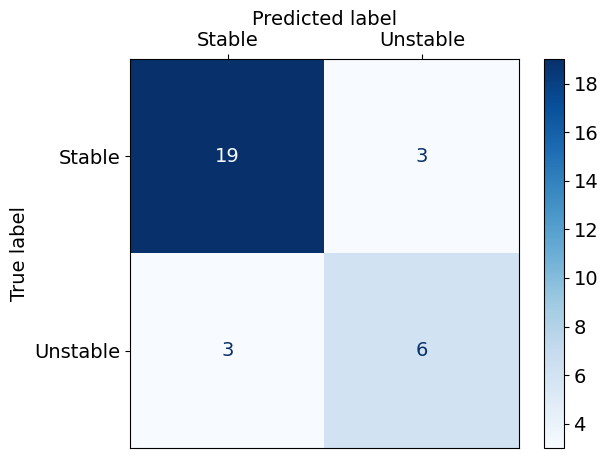

In [26]:
'''New grading scheme
'''
df_kinematic_new = pd.read_csv(os.path.join(configs['results_path'], 'kinematic_model', f'result_kinematic_ch_all.csv'))
all_preds = df_kinematic_new['Prediction'].to_list()
all_labels = df_kinematic_new['Ground Truth'].to_list()

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary', pos_label=1)
recall = recall_score(all_labels, all_preds, average='binary', pos_label=1)
weighted_accuracy = balanced_accuracy_score(all_labels, all_preds)

if precision + recall:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'weighted acc: {weighted_accuracy}')

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stable','Unstable'])
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
# fig.savefig('./figures/cm_kinematic_new.pdf', dpi=300)
fig.savefig('./figures/cm_kinematic_new.jpg', dpi=300)


#### Modified Unet on CT image data
Scripts for data processing, training, and testing are under folder 'image_model'.
- Usage:
    - python run.py grade_idx (grade_idx: 1 = old grading scheme, 2 = new grading scheme)
    - run.sh under linux environment
    
Use stored results for analysis

Accuracy: 0.2972972972972973
Precision: 0.20535714285714285
Recall: 0.26904761904761904
F1: 0.23292704785803905
weighted acc: 0.26904761904761904


/home/zeyut/.conda/envs/torch-1.13/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


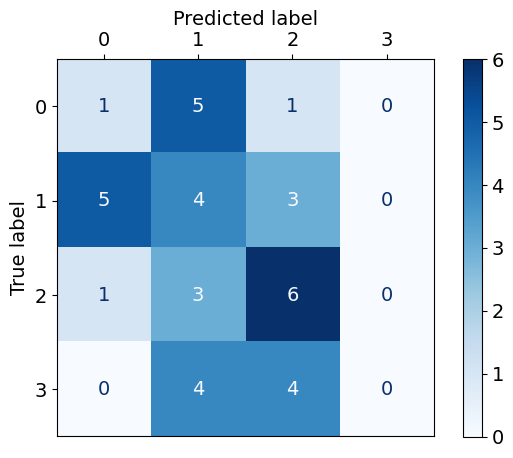

In [27]:
'''Old grading scheme
'''
df_image_old = pd.read_csv(os.path.join(configs['results_path'], 'image_model','result_old.csv'))
all_preds = df_image_old['Prediction'].to_list()
all_labels = df_image_old['Ground Truth'].to_list()

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
weighted_accuracy = balanced_accuracy_score(all_labels, all_preds)
if precision + recall:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'weighted acc: {weighted_accuracy}')


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
fig.savefig('./figures/cm_image_old.jpg', dpi=300)

Accuracy: 0.6756756756756757
Precision: 0.6571428571428571
Recall: 1.0
F1: 0.7931034482758621
weighted acc: 0.5714285714285714


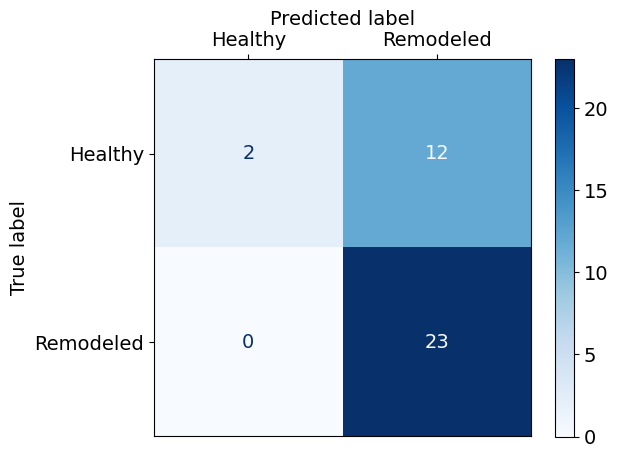

In [28]:
'''New grading scheme
'''
df_image_new = pd.read_csv(os.path.join(configs['results_path'], 'image_model','result_bony.csv'))
all_preds = df_image_new['Prediction'].to_list()
all_labels = df_image_new['Ground Truth'].to_list()

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary', pos_label=1)
recall = recall_score(all_labels, all_preds, average='binary', pos_label=1)
weighted_accuracy = balanced_accuracy_score(all_labels, all_preds)
if precision + recall:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'weighted acc: {weighted_accuracy}')


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy','Remodeled'])
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
fig.savefig('./figures/cm_image_new.jpg', dpi=300)


### Ensemble models
Use pre-saved results from each individual models. The cv folds are always identical

In [29]:
gt_path = configs['gt_path']
# Load ground truth labels and data
with open(configs['gt_path'], 'rb') as file:
    grades = pickle.load(file)
sample_codes = list(grades['old'].keys())

#### Old grading scheme

In [30]:
# Load data
df_static_old = pd.read_csv(os.path.join(configs['results_path'], 'static_model','result_old.csv'))
df_kinematic_old = pd.read_csv(os.path.join(configs['results_path'], 'kinematic_model', f'result_old_ch_all.csv'))
df_image_old = pd.read_csv(os.path.join(configs['results_path'], 'image_model','result_old.csv'))

In [31]:
from collections import Counter 
n_classes = 5
df_list = [df_static_old, df_kinematic_old, df_image_old]
def get_mode(arr):
    freq = Counter(arr) 
    return freq.most_common()[0][0]


In [32]:
# Essemble results in new grading scheme
preds = []
y_test = []

for hid in sample_codes:
    vote_pool = []
    cur_y = None
    for i, df in enumerate(df_list):
        if hid in df['Sample Code'].tolist():
            row = df.loc[df['Sample Code'] == hid]
            pred = row['Prediction'].values[0]
            vote_pool.append(pred)
            if cur_y == None:
                cur_y = row['Ground Truth'].values[0]
                
    if cur_y == None:
        print(f'{hid} has no available data')
        continue
    y_test.append(cur_y)    
    preds.append(get_mode(vote_pool))

y_test = np.array(y_test)
preds = np.array(preds)

H8 has no available data
J4 has no available data


Accuracy: 0.3157894736842105
Precision: 0.223109243697479
Recall: 0.2512087912087912
F1: 0.23632668080110739
weighted acc: 0.2512087912087912


/home/zeyut/.conda/envs/torch-1.13/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


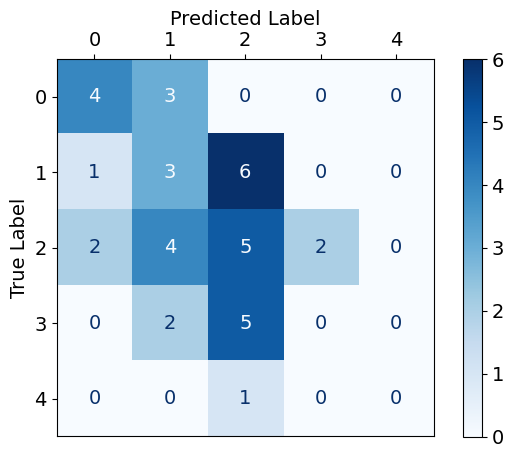

In [33]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')
weighted_accuracy = balanced_accuracy_score(y_test, preds)
if precision + recall:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'weighted acc: {weighted_accuracy}')

# Generate the confusion matrix
cm = confusion_matrix(y_test, preds, labels=np.unique(y_test))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label', fontsize=14)  
ax.set_ylabel('True Label', fontsize=14) 

ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
# fig.savefig('./figures/cm_old_grade_scheme.pdf')
fig.savefig('./figures/cm_old_grade_scheme.jpg',dpi=300)


#### New grading sheme

In [34]:
# Load data
df_static_new = pd.read_csv(os.path.join(configs['results_path'], 'static_model','result_ligament.csv'))
df_kinematic_new = pd.read_csv(os.path.join(configs['results_path'], 'kinematic_model','result_kinematic_ch_all.csv'))
df_image_new = pd.read_csv(os.path.join(configs['results_path'], 'image_model','result_bony.csv'))

In [35]:
n_classes = 3
df_list = [df_static_new, df_kinematic_new, df_image_new]

In [36]:
# Essemble results in new grading scheme
preds = []
y_test = []

for hid in sample_codes:
    sub_preds = np.zeros(3)
    cur_y = None
    for i, df in enumerate(df_list):
        if hid in df['Sample Code'].tolist():
            row = df.loc[df['Sample Code'] == hid]
            sub_preds[i] = row['Prediction'].values[0]
            if cur_y == None:
                cur_y = row['Ground Truth'].values[0]
    if cur_y == None:
        print(f'{hid} has no available data')
        continue
    if sub_preds[1] == 1:
        # Kinematic unstable (class number: 1) 
        # -> Peri-OA (class number: 1):
        preds.append(1)
    elif sub_preds[0] == 1:
        # Ligament attenuated (class number: 1) 
        # -> OA (class number: 2)
        preds.append(2)
    else:
        # Healthy (class number: 0)
        preds.append(0)
    y_test.append(grades['group'][hid])    
    
    

H8 has no available data
J4 has no available data


Accuracy: 0.631578947368421
Precision: 0.6240740740740741
Recall: 0.6064171122994652
F1: 0.6151189086958271
weighted acc: 0.6064171122994652


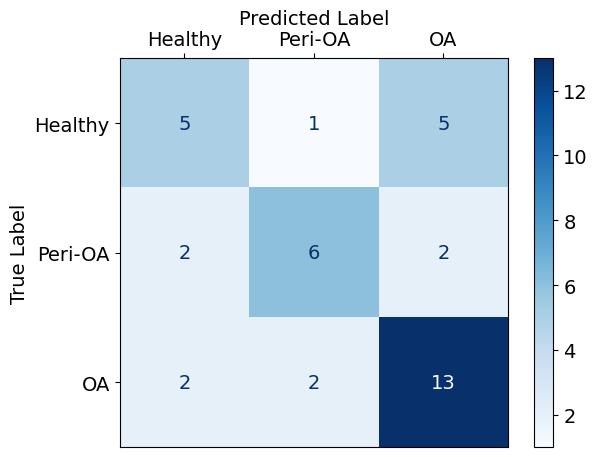

In [37]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average='macro')
recall = recall_score(y_test, preds, average='macro')
weighted_accuracy = balanced_accuracy_score(y_test, preds)
if precision + recall:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'weighted acc: {weighted_accuracy}')


# Generate the confusion matrix
cm = confusion_matrix(y_test, preds, labels=np.unique(y_test))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Peri-OA', 'OA'])
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label', fontsize=14)  
ax.set_ylabel('True Label', fontsize=14) 

ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
# fig.savefig('./figures/cm_new_grading_scheme.pdf')
fig.savefig('./figures/cm_new_grading_scheme.jpg',dpi=300)
